In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


In [2]:
# GPU or CPU device to use
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    ])

# choose the training and test datasets
train_data = datasets.MNIST('mnist_data', train=True,
                              download=True, transform=transform)
test_data = datasets.MNIST('mnist_data', train=False,
                             download=True, transform=transform)

print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist_data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
           )


In [4]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=512, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, num_workers=1)


tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5])


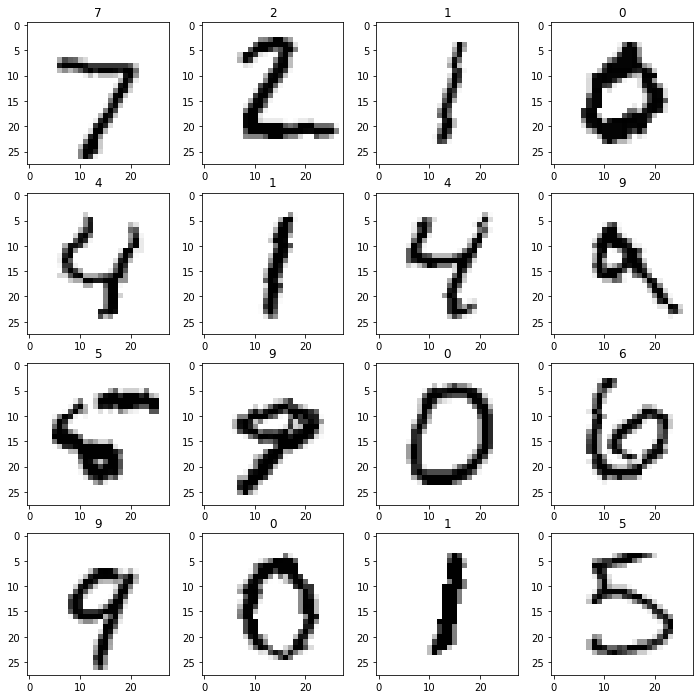

In [5]:
batch = next(iter(test_loader))
data, target = batch
print(target)

_data = data.data.cpu().numpy()
_target = target.data.cpu().numpy()

plt.figure(figsize=[12, 12])
for i in range(16):
    plt.subplot(4, 4, i+1)
    clazz = str(_target[i])
    plt.title(clazz)
    plt.imshow(_data[i][0], cmap='binary')
plt.show()


In [6]:
'''
source from : https://github.com/kumar-shridhar/PyTorch-BayesianCNN/blob/master/Image%20Recognition/utils/BBBlayers.py
'''

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter

class BBBConv2d(nn.Module):
    def __init__(self, q_logvar_init, p_logvar_init, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=False):
        super(BBBConv2d, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.q_logvar_init = q_logvar_init
        self.p_logvar_init = p_logvar_init
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.bias = bias

        self.mu_weight = Parameter(torch.Tensor(out_channels, in_channels // groups, kernel_size, kernel_size))
        self.sigma_weight = Parameter(torch.Tensor(out_channels, in_channels // groups, kernel_size, kernel_size))
        self.register_buffer('eps_weight', torch.Tensor(out_channels, in_channels // groups, kernel_size, kernel_size))
        
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        n *= self.kernel_size ** 2
        stdv = 1.0 / math.sqrt(n)
        self.mu_weight.data.uniform_(-stdv, stdv)
        self.sigma_weight.data.fill_(self.p_logvar_init)

    def forward(self, input):
        raise NotImplementedError()


    def convprobforward(self, input):
        sig_weight = torch.exp(self.sigma_weight)
        weight = self.mu_weight + sig_weight * self.eps_weight.normal_()
        kl_ = math.log(self.q_logvar_init) - self.sigma_weight + (sig_weight**2 + self.mu_weight**2) / (2 * self.q_logvar_init ** 2) - 0.5
        bias = None
        
        out = F.conv2d(input, weight, bias, self.stride, self.padding, self.dilation, self.groups)
        kl = kl_.sum() 
        return out, kl


class BBBLinearFactorial(nn.Module):
    def __init__(self, q_logvar_init, p_logvar_init, in_features, out_features, bias=False):
        super(BBBLinearFactorial, self).__init__()
        self.q_logvar_init = q_logvar_init
        self.in_features = in_features
        self.out_features = out_features
        self.p_logvar_init = p_logvar_init
        self.mu_weight = Parameter(torch.Tensor(out_features, in_features))
        self.sigma_weight = Parameter(torch.Tensor(out_features, in_features))
        self.register_buffer('eps_weight', torch.Tensor(out_features, in_features))
        
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.mu_weight.size(1))
        self.mu_weight.data.uniform_(-stdv, stdv)
        self.sigma_weight.data.fill_(self.p_logvar_init)
        self.eps_weight.data.zero_()

    def forward(self, input):
        raise NotImplementedError()
        

    def fcprobforward(self, input):
        sig_weight = torch.exp(self.sigma_weight)
        weight = self.mu_weight + sig_weight * self.eps_weight.normal_()
        kl_ = math.log(self.q_logvar_init) - self.sigma_weight + (sig_weight**2 + self.mu_weight**2) / (2 * self.q_logvar_init ** 2) - 0.5
        bias = None
        out = F.linear(input, weight, bias)
        kl = kl_.sum() 
        return out, kl

In [7]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.q_logvar_init = 0.05
        self.p_logvar_init = np.log(0.05)
        
        self.convs = nn.ModuleList([BBBConv2d(self.q_logvar_init, self.p_logvar_init, 1, 32, kernel_size=3, stride=1, padding=1),
                                   BBBConv2d(self.q_logvar_init, self.p_logvar_init, 32, 32, kernel_size=3, stride=1),
                                   BBBConv2d(self.q_logvar_init, self.p_logvar_init, 32, 64, kernel_size=3, stride=1, padding=1),
                                   BBBConv2d(self.q_logvar_init, self.p_logvar_init, 64, 64, kernel_size=3, stride=1)])
        
        self.linears = nn.ModuleList([BBBLinearFactorial(self.q_logvar_init, self.p_logvar_init, 64 * 5 * 5, 512),
                                     BBBLinearFactorial(self.q_logvar_init, self.p_logvar_init, 512, 10)])
        
    def forward(self, x, t):
        '''
        x : [batch, channel=1, width=32, height=32]
        t : [batch]
        '''
        
        kl = 0
        y, _kl = self.convs[0].convprobforward(x)
        kl += _kl
        y = F.relu(y)
        y, _kl = self.convs[1].convprobforward(y)
        kl += _kl
        y = F.relu(y)
        y = F.max_pool2d(y, kernel_size=2)
        #y = F.dropout(y, p=0.25)
        
        y, _kl = self.convs[2].convprobforward(y)
        kl += _kl
        y = F.relu(y)
        y, _kl = self.convs[3].convprobforward(y)
        kl += _kl
        y = F.relu(y)
        y = F.max_pool2d(y, kernel_size=2)
        #y = F.dropout(y, p=0.25)
        
        y = y.view(-1, 64 * 5 * 5)
        y, _kl = self.linears[0].fcprobforward(y)
        kl += _kl
        y = F.relu(y)
        #y = F.dropout(y, p=0.5)
        y, _kl = self.linears[1].fcprobforward(y)
        kl += _kl
        
        return y, kl


In [8]:
import os
from tensorboardX import SummaryWriter

class Logger(SummaryWriter):
    def __init__(self, logdir):
        super(Logger, self).__init__(logdir)

    def log(self, log_string, value, iteration):
            self.add_scalar(log_string, value, iteration)

save_dir = 'save/BBB_CNN_mnist'
#!rm -rf $save_dir

logger = Logger(save_dir)

!ls $save_dir


events.out.tfevents.1580584151.scpark-X299-WU8	save_11000
events.out.tfevents.1580584192.scpark-X299-WU8	save_12000
events.out.tfevents.1580584246.scpark-X299-WU8	save_13000
events.out.tfevents.1580584290.scpark-X299-WU8	save_14000
events.out.tfevents.1580584321.scpark-X299-WU8	save_15000
events.out.tfevents.1580584349.scpark-X299-WU8	save_2000
events.out.tfevents.1580584386.scpark-X299-WU8	save_3000
events.out.tfevents.1580584739.scpark-X299-WU8	save_4000
events.out.tfevents.1580585238.scpark-X299-WU8	save_5000
events.out.tfevents.1580586866.scpark-X299-WU8	save_6000
events.out.tfevents.1580931359.scpark-X299-WU8	save_7000
save_0						save_8000
save_1000					save_9000
save_10000


In [9]:
model = Model().to(DEVICE)
print(model)

optimizer = torch.optim.Adam(model.parameters(), 1e-4)
print(optimizer)

step = 15000
path = save_dir + '/' + 'save_' + str(step)
if os.path.exists(path) and True:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    step = checkpoint['step']
    step += 1
    print('checkpoint loaded')
    

Model(
  (convs): ModuleList(
    (0): BBBConv2d()
    (1): BBBConv2d()
    (2): BBBConv2d()
    (3): BBBConv2d()
  )
  (linears): ModuleList(
    (0): BBBLinearFactorial()
    (1): BBBLinearFactorial()
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
checkpoint loaded


2


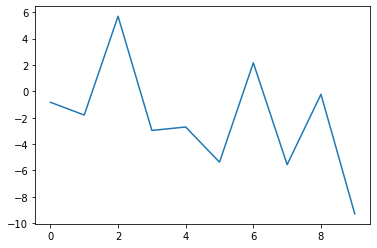

53 43.81744384765625 23356.267578125
54 18.47333526611328 23356.994140625
55 34.61076354980469 23357.955078125
56 33.30970764160156 23358.748046875
57 28.083351135253906 23359.455078125
58 68.68896484375 23360.779296875
59 35.253780364990234 23363.01171875
60 51.73577880859375 23365.52734375
61 49.5289192199707 23368.275390625
62 28.451419830322266 23371.3828125
63 32.472373962402344 23374.576171875
64 30.578720092773438 23378.0234375
65 37.18683624267578 23381.486328125
66 13.042936325073242 23384.169921875
67 37.11183166503906 23386.259765625
68 35.42414855957031 23387.630859375
69 33.39513397216797 23388.267578125
70 38.17704391479492 23388.19140625
71 62.87916564941406 23388.287109375
72 41.4243278503418 23389.52734375
73 43.46393966674805 23390.712890625
74 43.035396575927734 23391.498046875
75 33.978275299072266 23392.453125
76 41.149227142333984 23392.5859375
77 37.168277740478516 23392.166015625
78 26.185073852539062 23391.4921875
79 40.709617614746094 23390.87109375
80 63.1294

KeyboardInterrupt: 

In [13]:
from IPython import display
import matplotlib.pyplot as plt

model.train()

while(True):
    for batch_index, batch in enumerate(train_loader):

        x, t = batch
        x = x.to(DEVICE)
        t = t.to(DEVICE)

        model.zero_grad()
        y, kl_loss = model(x, t)

        loss = nn.CrossEntropyLoss(reduction='sum')(y, t)
        total_loss = loss + 1 / x.size(0) * kl_loss
        total_loss.backward()
        optimizer.step()

        print(batch_index, loss.item(), kl_loss.item())
        
        if step % 10 == 0:
            logger.log('loss', loss.item(), step)

        if step % 1000 == 0:
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)

            path = save_dir + '/' + 'save_' + str(step)
            torch.save({
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, path)
            print('saved', path)
            
            '''
            Test
            '''
            correct = []
            for batch_index, batch in enumerate(test_loader):

                    x, t = batch
                    x = x.to(DEVICE)
                    t = t.to(DEVICE)

                    y, _ = model(x, t)
                    _y = y.data.cpu().numpy()
                    _y = np.argmax(_y, axis=1)
                    _t = t.data.cpu().numpy()

                    correct.append((_y == _t))

            correct = np.concatenate(correct)
            precision = np.sum(correct) / len(correct)

            logger.log('test precision', precision, step)

        if step % 100 == 0:
            display.clear_output()
            _y = y.data.cpu().numpy()
            _t = t.data.cpu().numpy()
            print(_t[0])
            plt.plot(_y[0])
            plt.show()
         
        step += 1
        

In [14]:
correct = []
for batch_index, batch in enumerate(test_loader):

        x, t = batch
        x = x.to(DEVICE)
        t = t.to(DEVICE)
        
        y_list = []
        for _ in range(100):
            y, _ = model(x, t)
            y = F.softmax(y)
            y_list.append(y)
        ys = torch.stack(y_list)
        
        _ys = ys.data.cpu().numpy()
        _y = np.mean(_ys, axis=0)
        _y = np.argmax(_y, axis=1)
        _t = t.data.cpu().numpy()

        correct.append((_y == _t))
        break

correct = np.concatenate(correct)
precision = np.sum(correct) / len(correct)
print(precision)


/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


1.0


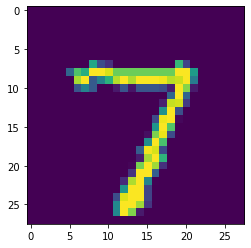

1.5092506e-07


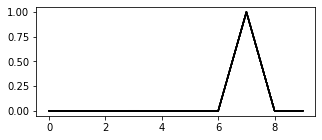

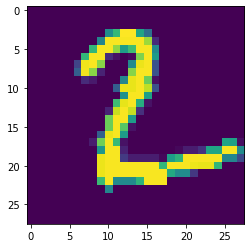

0.00013117406


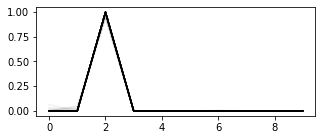

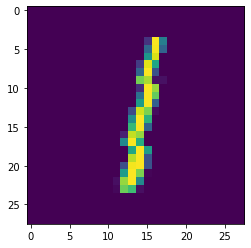

2.5631596e-05


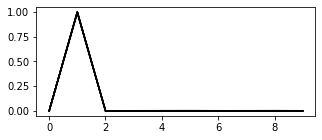

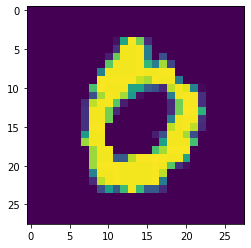

8.877744e-06


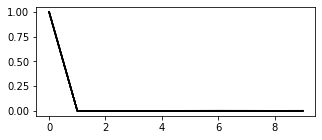

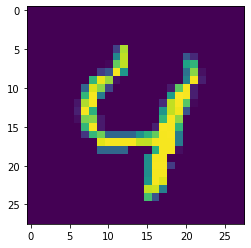

2.8080414e-05


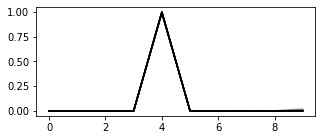

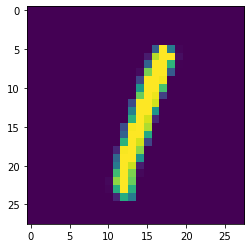

6.3363054e-06


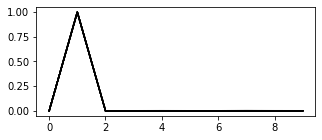

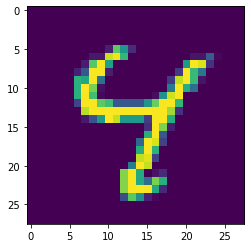

0.05092067


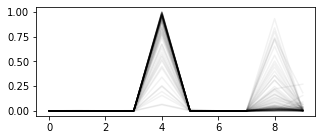

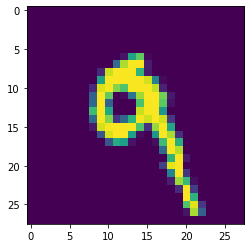

5.7358127e-05


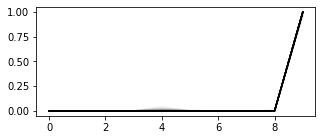

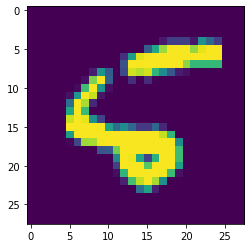

0.01867826


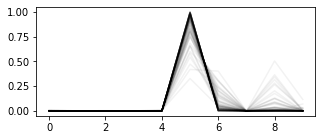

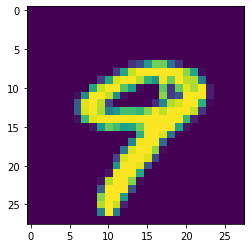

0.00014021226


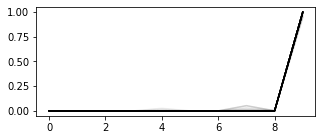

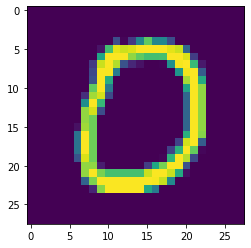

5.0255803e-06


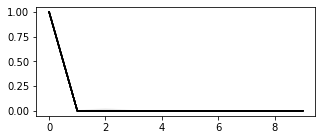

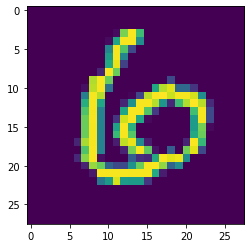

3.808522e-06


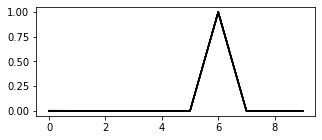

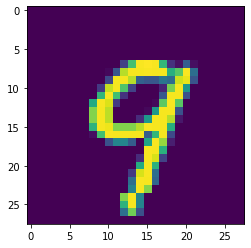

8.835206e-06


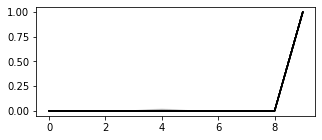

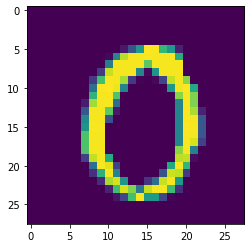

6.0111133e-06


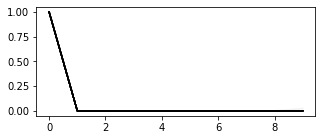

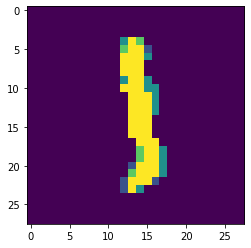

0.00016332924


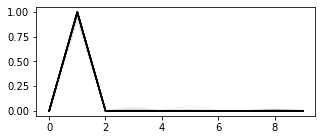

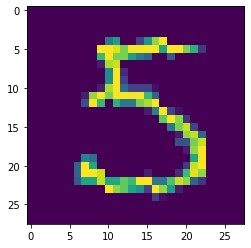

0.013714693


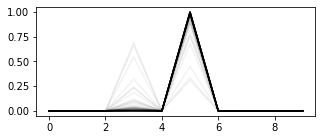

In [15]:
_x = x.data.cpu().numpy()

for i in range(16):
    plt.imshow(_x[i, 0])
    plt.show()
    
    _mean = np.mean(_ys[:, i], axis=0)
    _argmax = np.argmax(_mean)
    _variance = np.var(_ys[:, i, _argmax])
    print(_variance)
    
    np.argmax(_ys[:, i], axis=1)
    
    plt.figure(figsize=[5, 2])
    plt.plot(_ys[:, i].T, alpha=0.05, color='black')
    plt.show()
    